##Required Libraries


In [1]:
# installing the library needed
install.packages('survey')
install.packages("srvyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘minqa’, ‘numDeriv’, ‘mitools’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# Load the 'dplyr' package for data manipulation
library(dplyr)

# Load the 'survey' package for survey design and analysis
library(survey)

# Load the 'srvyr' package for survey data manipulation and analysis
library(srvyr)

# Load the 'ggplot2' package for data visualization
library(ggplot2)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

Loading required package: Matrix

Loading required package: survival


Attaching package: ‘survey’


The following object is masked from ‘package:graphics’:

    dotchart



Attaching package: ‘srvyr’


The following object is masked from ‘package:stats’:

    filter




## Reading Data Files

In [3]:
# Read the data files
adult19 <- read.csv("adult19.csv")
adult20 <- read.csv("adult20.csv")
adult21 <- read.csv("adult21.csv")

# Adding the year colum
adult19$year <- "2019"
adult20$year <- "2020"
adult21$year <- "2021"

### Exploring each year sample size

In [4]:
print(dim(adult19))
print(dim(adult20))
print(dim(adult21))

[1] 31997   535
[1] 31568   618
[1] 29482   623


### Exploring each year population size

In [5]:
print(sum(adult19$WTFA_A))
print(sum(adult20$WTFA_A))
print(sum(adult21$WTFA_A))

[1] 250916569
[1] 252052044
[1] 253157754


#Data Preparation


##Selecting and Renaming Columns
We begin by selecting only the columns of interest from the datasets for the years 2019, 2020, and 2021.

After selecting the relevant columns, we rename them for consistency and clarity across the three datasets.

In [6]:
# column we intrested in
columns <- c('HHX','DEPEV_A','PAIWKLM3M_A','ANXEV_A','PAIFRQ3M_A','AGEP_A','SOCERRNDS_A','SOCSCLPAR_A','SOCWRKLIM_A','SEX_A','INTV_QRT','WTFA_A','PSTRAT','PPSU','year','HISPALLP_A','HOSPONGT_A','PHSTAT_A','MARSTAT_A','EMPLSTWORK_A')
adult19_new <- adult19[,columns]
adult20_new <- adult20[,columns]

columns <- c('HHX','DEPEV_A','PAIWKLM3M_A','ANXEV_A','PAIFRQ3M_A','AGEP_A','SOCERRNDS_A','SOCSCLPAR_A','SOCWRKLIM_A','SEX_A','INTV_QRT','WTFA_A','PSTRAT','PPSU','year','HISPALLP_A','HOSPONGT_A','PHSTAT_A','MARSTAT_A','EMPLSTWOR1_A')
adult21_new <- adult21[,columns]

# rename the column name
columns <- c('HHX','DEP','IMPACT_P','ANX','PAIN','AGE','ERRANED','SOCIAL','WORK','SEX','QRT','WWIGHT','STRAT','PSU','year','Race','Overnight','Health','Marital','Employment')
names(adult19_new) <- columns
names(adult20_new) <- columns
names(adult21_new) <- columns


## Data Combination and Initial Cleaning
To begin the cleaning process, we first combine the datasets for the years 2019, 2020, and 2021 into a single data frame, `nhis_combind`. This allows us to perform subsequent analyses and transformations on the combined data.

In [7]:
# Combine datasets from 2019, 2020, and 2021
nhis_combind <- bind_rows(adult19_new,adult20_new ,adult21_new)

# Display the dimensions of the combined dataset
dim(nhis_combind)

[1] 93047    20

## Chronic Pain Classification

**Step 1:** Analyze the Distribution of Chronic Pain First, we explore the distribution of the `PAIN` variable in the combined dataset to understand the prevalence of different pain categories.

**Step 2:** Create a Binary Label for Chronic Pain We then classify the PAIN variable into a binary label (CP_classified). This variable will indicate whether a participant is experiencing chronic pain based on their responses.

Specifically:
- A value of TRUE indicates chronic pain (PAIN values of 3 or 4).
- A value of FALSE indicates no chronic pain (PAIN values of 1 or 2).
- Missing data (PAIN values of 7, 8, 9) are set to NA.

**Step 3:** Examine the New Binary Classification
Finally, we check the distribution of the newly created CP_classified variable and identify any missing values.

In [8]:
# following the code book we will start by chronic pain
table(nhis_combind$PAIN)
# we will make new binary label to classify this variable
nhis_combind$CP_classified = case_when(
  nhis_combind$PAIN %in% c(1,2) ~FALSE,
  nhis_combind$PAIN %in% c(3,4) ~TRUE,
  nhis_combind$PAIN %in% c(7,8,9) ~NA,
  )
table(nhis_combind$CP_classified)
sum(is.na(nhis_combind$CP_classified))


    1     2     3     4     7     8     9 
33765 36155  7823 13446    85  1554    62 


FALSE  TRUE 
69920 21269 

[1] 1858

## A/D Classification

**Step 1:** Analyze the Distribution of Anxiety and Depression
We start by examining the distribution of the `ANX` (Anxiety) and `DEP` (Depression) variables in the combined dataset.

**Step 2:** Create Binary Labels for Depression and Anxiety
Next, we classify the ANX and DEP variables into binary labels (AN_classified and DP_classified). These variables indicate whether a participant has been diagnosed with anxiety or depression:

- A value of TRUE indicates a diagnosis (ANX or DEP values of 1).
- A value of FALSE indicates no diagnosis (ANX or DEP values of 2).
- Missing data (ANX or DEP values of 7, 8, 9) are set to NA.

Additionally, we create a new variable AorD, which indicates whether a participant has either anxiety or depression (or both).

**Step 3:** Examine the New Classifications
We then check the distribution of the new AorD variable to see how many participants have either anxiety or depression. We also check for any missing values in the newly created DP_classified, AN_classified, and AorD variables.

In [9]:
# following the code book we will classify the Depression and Anxitey
table(nhis_combind$ANX)
table(nhis_combind$DEP)
nhis_combind <- nhis_combind %>%
    mutate(
      DP_classified = case_when( DEP == 1 ~TRUE,
                                 DEP == 2 ~FALSE,
                                 DEP %in% c(7,8,9) ~NA),
      AN_classified = case_when( ANX == 1 ~TRUE,
                                 ANX == 2 ~FALSE,
                                 ANX %in% c(7,8,9) ~NA),
      AorD = ( DP_classified | AN_classified) )

table(nhis_combind$AorD)

sum(is.na(nhis_combind$AorD))
sum(is.na(nhis_combind$DP_classified))
sum(is.na(nhis_combind$AN_classified))


    1     2     7     9 
14505 78389    87    66 


    1     2     7     9 
16317 76559    91    80 


FALSE  TRUE 
71895 20979 

[1] 173

[1] 171

[1] 153

## Other Variables Classifying
**Step 1:** Replacing Missing Values
We begin by replacing specific missing values (coded as 7, 8, or 9) with `NA` across several variables (`ERRANED`, `SOCIAL`, `WORK`, `SEX`, `IMPACT_P`, `Employment`, `Health`, and `Overnight`).

**Step 2:** Defining Key Conditions and Classifications
We then define several key conditions and classifications:

- Condition: Categorizes participants into four groups:
##### 1. "Both": Participants with both chronic pain and anxiety/depression.
##### 2. "Chronic Pain Only": Participants with chronic pain only.
##### 3. "A/D Only": Participants with anxiety/depression only.
##### 4. "Neither": Participants with neither condition.

- Co-occurring: A boolean variable indicating if both chronic pain and anxiety/depression are present.

- High_CP: Classifies chronic pain impact as either "High Impact" or "Low Impact" based on IMPACT_P.

- erraned, social, work: Boolean variables derived from ERRANED, SOCIAL, and WORK, indicating if these aspects were impacted.

- SEX: Recodes the SEX variable into "MALE" or "FEMALE".

- Race: Categorizes race into specific groups, such as "Hispanic", "White, NH", and "Black/African American, NH".

- Marital: Classifies marital status into categories such as "Married", "Widowed", "Divorced or separated", etc.

- Employment: Recodes employment status into categories such as "Employed" or "NE, worked previously".

- Overnight: A boolean variable indicating if participants spent a night in a hospital.

- Health: Classifies health status into "Good" or "Poor" based on the participant's self-reported health.

**Step 3:** Categorizing Age into Groups
Lastly, we categorize participants' ages into three groups: "18-44", "45-64", and "65+". We also handle any missing age data by setting values of 97 and above to NA.

In [10]:
nhis_combind <- nhis_combind %>%
      mutate(
      # Replace missing values in specified variables
      across(c(ERRANED,SOCIAL, WORK,SEX,IMPACT_P,Employment,Health,Overnight),
       ~replace(., . == 7 |     . == 8 | . == 9, NA))
       )%>%

      # Define key conditions and classifications
        mutate(
          Condition = case_when(
            CP_classified & AorD ~"Both",
            CP_classified ~"Chronic Pain Only",
            AorD ~"A/D Only",
            .default = "Neither"
            ),

          cooccuring = if_else(
            CP_classified & AorD , TRUE,FALSE
            ),

          High_CP = case_when( IMPACT_P %in% c(3,4) ~ "High Impact",
            IMPACT_P %in% c(1,2) ~"Low Impact"),

          erraned = case_when(
              ERRANED == 1 ~ FALSE,
             ERRANED %in% c(2,3,4) ~ TRUE
             ),

          social = case_when(
              SOCIAL == 1 ~ FALSE,
             SOCIAL %in% c(2,3,4) ~ TRUE
             ),

          work = case_when(
              WORK == 1 ~ TRUE,
             WORK == 2 ~ FALSE
             ),

          SEX = case_when(
            SEX == 1 ~ "MALE",
            SEX == 2 ~ "FEMALE"
             ),

          Race = case_when(
            Race == 1~"Hispanic",
            Race == 2~"White, NH",
            Race == 3~"Black/African America, NH",
            Race == 4~"Asian, NH",
            Race == 5~"AI/AN, NH",
            Race %in% c(6,7) ~"Other single and multi race",
            Race %in% c(97,98,99) ~ NA
          ),

          Marital = case_when(
            Marital %in% c(1,2,3) ~ "Married",
            Marital == 4 ~ "Widowed",
            Marital %in% c(5,6) ~ "Divorced or separated",
            Marital == 7 ~ "Never Married",
            Marital == 8 ~ "Living with partner",
            Marital == 9 ~ NA
          ),

          Employment = case_when(
            Employment == 1 ~ "Emplyed",
            Employment %in% c(2,3) ~ "NE, worked previously",
            Employment == 4 ~ "NE, never worked",
          ),

          Overnight = case_when(
            Overnight == 1 ~TRUE,
            Overnight == 2 ~FALSE
          ),

          Health = case_when(
            Health %in% c(1,2,3) ~"Good",
            Health %in% c(4,5) ~"Poor"
          )

        )

  # Handle missing age data and categorize age into groups
  nhis_combind$AGE[nhis_combind$AGE >= 97 ] <- NA
  nhis_combind$age_group <- cut(nhis_combind$AGE,
                        breaks = c(18,44,64,Inf),
                        labels = c("18-44","45-64","65+"),
                        right = FALSE)

## Data Filtering and Summary Statistics
To ensure the accuracy of our analysis, we filter the dataset to include only those observations where both the `CP_classified` and `AorD` variables are not missing.

After filtering, we proceed to summarize the dataset by year to understand the distribution of our data across the three years of interest.

In [11]:
# Count the number of non-missing observations for both CP_classified and AorD
sum(!is.na(nhis_combind$CP_classified) & !is.na(nhis_combind$AorD))

# Subset the data to include only rows where CP_classified and AorD are not missing
nhis_combind <- subset(nhis_combind, !is.na(CP_classified) & !is.na(AorD))

# Summarize the number of observations for each year
sum(nhis_combind$year==2019)
sum(nhis_combind$year==2020)
sum(nhis_combind$year==2021)

# Calculate the total sum of the survey weights divided by 3
sum(nhis_combind$WWIGHT/3)

[1] 91058

[1] 31260

[1] 31081

[1] 28717

[1] 246223121

## Adjusting Survey Weights

Since we combined data from multiple years, we need to adjust the survey weights to account for the combined dataset. Following the NHIS guide in this part,the adjustment is done by dividing the original survey weights by the number of years (in this case, 3).

In [12]:
# we need an adj weight because we have combind the data
nhis_combind$adj_w <- nhis_combind$WWIGHT/3

## Creating the Survey Design Object
To analyze the survey data properly, we define a survey design object using the `svydesign` function. This object incorporates the survey design features such as primary sampling units (PSU), strata, and weights, which are essential for accurate statistical analysis.


In [13]:
# Define the survey design object
survey_design <- svydesign(ids = ~PSU,
                           strata = ~STRAT,
                           weights = ~adj_w,
                           data = nhis_combind,
                           nest = TRUE)

# Generate and review the summary of the survey design object
summary(survey_design)

Stratified 1 - level Cluster Sampling design (with replacement)
With (656) clusters.
svydesign(ids = ~PSU, strata = ~STRAT, weights = ~adj_w, data = nhis_combind, 
    nest = TRUE)
Probabilities:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
2.465e-05 2.981e-04 4.493e-04 5.729e-04 7.239e-04 7.572e-03 
Stratum Sizes: 
            100  101  102  103  104  105  106  107  108  109  110  111 112  113
obs        1964 2222 1890 1549 1474 1769 2253 2507 2196 2225 1983 1656 532 2651
design.PSU   16   18   14   11   10   13   16   20   14   16   15   10   4   18
actual.PSU   16   18   14   11   10   13   16   20   14   16   15   10   4   18
            114  115 116  117  118  119  120  121  122 123  124  125  126  127
obs        1333 1792 695 2100 1916 2530 1489 1619 1902 918 1766 1411 1968 1395
design.PSU    9   15   7   15   14   15   11   11   15   7   14   10   15   10
actual.PSU    9   15   7   15   14   15   11   11   15   7   14   10   15   10
           128  129  130  131 

## Calculating Prevalence of Chronic Pain and Anxiety/Depression
To determine the prevalence of chronic pain and anxiety/depression, we use the `srvyr` package to calculate survey means and totals. The `Clopper-Pearson` method is used for confidence intervals, providing a reliable measure of uncertainty.

In [14]:
# Define the survey design using srvyr
srvyr_design <- as_survey_design(survey_design)

# Calculate the survey mean with Clopper-Pearson confidence intervals
CP <- srvyr_design %>%
  summarise(
    n = sum(CP_classified==TRUE),
    mean = round(survey_mean(CP_classified, vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",na.rm = TRUE)*100, 2),
    total = round(survey_total(CP_classified, vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",na.rm = TRUE)/1000000, 2),
  )
CP

# Calculate the prevalence of anxiety/depression with Clopper-Pearson confidence intervals
AD <- srvyr_design %>%
  summarise(
    n = sum(AorD==TRUE),
    mean = round(survey_mean(AorD, vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",na.rm = TRUE)*100 , 2),
    total = round(survey_total(AorD, vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",na.rm = TRUE)/1000000 ,2),
  )
AD

n,mean,mean_low,mean_upp,total,total_low,total_upp
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21221,21.04,20.56,21.52,51.8,49.81,53.78


n,mean,mean_low,mean_upp,total,total_low,total_upp
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20635,21.58,21.1,22.06,53.12,51.03,55.22


###Prevalence by Year
To analyze the prevalence of chronic pain and anxiety/depression over the years, we compute the summary statistics grouped by year.

In [15]:
# Calculate prevalence of chronic pain by year
CP.year <- srvyr_design %>%
  group_by(year) %>%
    summarise(
    n = sum(CP_classified==TRUE),
    mean = round(survey_mean(CP_classified, vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",na.rm =TRUE)*100, 2),
    total = round(survey_total(CP_classified, vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",na.rm =TRUE)*3/1000000, 2),
  )
CP.year

# Calculate prevalence of anxiety/depression by year
AD.year <- srvyr_design %>%
  group_by(year) %>%
  summarise(
    n = sum(AorD==TRUE),
    mean = round(survey_mean(AorD, vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",na.rm =TRUE)*100 , 2),
    total = round(survey_total(AorD, vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",na.rm =TRUE)*3/1000000 ,2),
  )
AD.year

year,n,mean,mean_low,mean_upp,total,total_low,total_upp
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019,7167,20.51,19.90,21.14,50.11,47.78,52.44
2020,7401,21.72,21.04,22.42,53.84,51.32,56.37
2021,6653,20.87,20.23,21.52,51.44,49.22,53.66


year,n,mean,mean_low,mean_upp,total,total_low,total_upp
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019,6755,20.18,19.54,20.83,49.30,46.95,51.65
2020,7094,21.71,21.01,22.42,53.81,51.23,56.39
2021,6786,22.82,22.15,23.51,56.26,53.69,58.82


###Visualizing Prevalence by Year

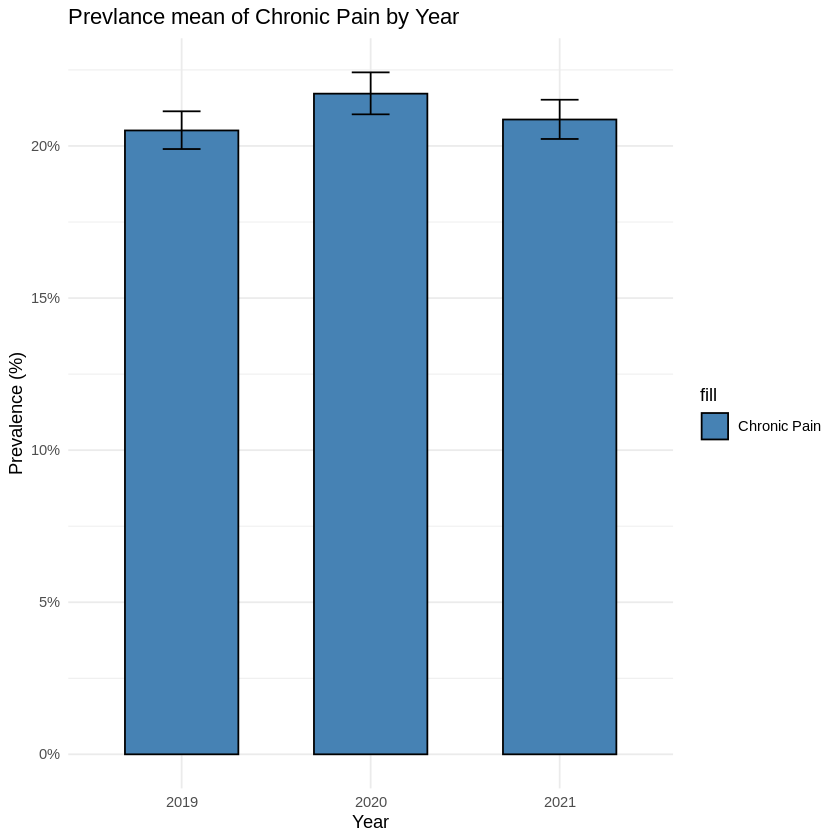

In [16]:
# Create a bar plot for chronic pain prevalence by year
CP.plot <- ggplot(CP.year, aes(x = as.factor(year), y = mean, fill = "Chronic Pain")) +
  geom_bar(stat = "identity", color = "black", width = 0.6) +
  geom_errorbar(aes(ymin = mean_low, ymax = mean_upp), width = 0.2) +
  labs(title = "Prevlance mean of Chronic Pain by Year",
       x = "Year",
       y = "Prevalence (%)") +
  theme_minimal() +
  scale_y_continuous(labels = scales::percent_format(scale = 1))+
  scale_fill_manual(values = c("Chronic Pain" = "steelblue"))

CP.plot

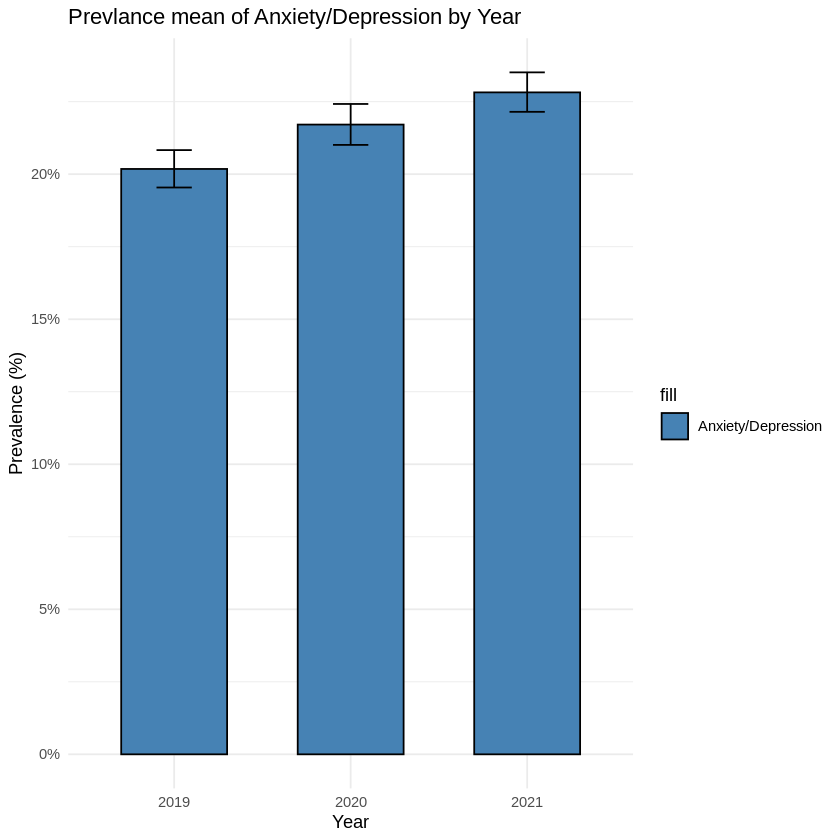

In [17]:
# Create a bar plot for Anxiety/Depression prevalence by year
AD.plot <- ggplot(AD.year, aes(x = as.factor(year), y = mean, fill = "Anxiety/Depression")) +
  geom_bar(stat = "identity", color = "black", width = 0.6) +
  geom_errorbar(aes(ymin = mean_low, ymax = mean_upp), width = 0.2) +
  labs(title = "Prevlance mean of Anxiety/Depression by Year",
       x = "Year",
       y = "Prevalence (%)") +
  theme_minimal() +
  scale_y_continuous(labels = scales::percent_format(scale = 1))  +
  scale_fill_manual(values = c("Anxiety/Depression" = "steelblue"))
AD.plot

##Chi-Square Tests for Association Between Chronic Pain and Anxiety/Depression
To analyze the association between chronic pain (`CP_classified`) and anxiety/depression (`AorD`), we perform chi-square tests for each year. These tests assess whether there is a significant relationship between the two conditions.


In [18]:
# Perform chi-square test for 2019
svychisq(~CP_classified+AorD, design = subset(survey_design,year==2019))
# Perform chi-square test for 2020
svychisq(~CP_classified+AorD, design = subset(survey_design,year==2020))
# Perform chi-square test for 2021
svychisq(~CP_classified+AorD, design = subset(survey_design,year==2021))


	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~CP_classified + AorD, design = subset(survey_design,     year == 2019))
F = 1401.5, ndf = 1, ddf = 556, p-value < 2.2e-16



	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~CP_classified + AorD, design = subset(survey_design,     year == 2020))
F = 868.8, ndf = 1, ddf = 571, p-value < 2.2e-16



	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~CP_classified + AorD, design = subset(survey_design,     year == 2021))
F = 988.08, ndf = 1, ddf = 591, p-value < 2.2e-16


## Prevalence of Co-occurrence of Chronic Pain and Anxiety/Depression
To assess the prevalence of co-occurring chronic pain and anxiety/depression, we calculate the proportion of individuals who experience both conditions simultaneously. This involves summarizing the `cooccuring` variable.


In [19]:
CO <- srvyr_design %>%
  summarise(
    count = sum(cooccuring),
    mean = round(survey_mean(cooccuring, vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",na.rm = TRUE)*100, 2),
    total = round(survey_total(cooccuring, vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",na.rm = TRUE)/1000000, 2),
  )
CO

count,mean,mean_low,mean_upp,total,total_low,total_upp
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8392,8.28,7.99,8.58,20.39,19.42,21.36


Calculating Yearly Prevalence of Co-occurrenc

In [20]:
CO.year <- srvyr_design %>%
  group_by(year) %>%
  summarise(
    count = sum(cooccuring),
    mean = round(survey_mean(cooccuring, vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",na.rm = TRUE)*100, 2),
    total = round(survey_total(cooccuring, vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",na.rm = TRUE)*3/1000000, 2),
  )
CO.year$Condition = "cooccuring"
CO.year

year,count,mean,mean_low,mean_upp,total,total_low,total_upp,Condition
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2019,2880,8.22,7.80,8.66,20.09,18.83,21.34,cooccuring
2020,2852,8.27,7.85,8.72,20.51,19.23,21.79,cooccuring
2021,2660,8.35,7.96,8.76,20.58,19.41,21.75,cooccuring


##Combined Bar Plot of Chronic Pain and Anxiety/Depression by Year

The combined bar plot visualizes the prevalence of chronic pain and anxiety/depression conditions across different years. The plot includes separate bars for each condition, allowing for an easy comparison of their rates over time.


## Prevalence of Conditions

In [22]:
cond.C <- srvyr_design %>%
  summarise(
    count = sum(Condition=="Chronic Pain Only"),
    mean = round(survey_mean(Condition=="Chronic Pain Only", vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson")*100, 2),
    total = round(survey_total(Condition=="Chronic Pain Only", vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson")/1000000, 2),
  )
cond.C

cond.A <- srvyr_design %>%
  summarise(
    count = sum(Condition=="A/D Only"),
    mean = round(survey_mean(Condition=="A/D Only", vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson")*100, 2),
    total = round(survey_total(Condition=="A/D Only", vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson")/1000000, 2),
  )
cond.A

cond.N <- srvyr_design %>%
  summarise(
    count = sum(Condition=="Neither"),
    mean = round(survey_mean(Condition=="Neither", vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson")*100, 2),
    total = round(survey_total(Condition=="Neither", vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson")/1000000, 2),
  )
cond.N

count,mean,mean_low,mean_upp,total,total_low,total_upp
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12829,12.75,12.44,13.08,31.4,30.16,32.65


count,mean,mean_low,mean_upp,total,total_low,total_upp
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12243,13.29,12.96,13.63,32.73,31.37,34.1


count,mean,mean_low,mean_upp,total,total_low,total_upp
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
57594,65.67,65.08,66.26,161.7,156.11,167.29


## Co-occurrence of Chronic Pain and Anxiety/Depression by Age Group


In [23]:
# Filter, group by age_group, and count the rows where co-occuring
CO_by_age_group <- srvyr_design %>%
  group_by(age_group) %>%
  summarise(count = sum(cooccuring==TRUE),
            mean = round(survey_mean(cooccuring ,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson", na.rm=TRUE)*100 ,1),
            total = round(survey_total(cooccuring ,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson", na.rm=TRUE)/1000000 ,1),
            )

# Summary Table
print(CO_by_age_group)

# A tibble: 4 × 8
  age_group count  mean mean_low mean_upp total total_low total_upp
  <fct>     <int> <dbl>    <dbl>    <dbl> <dbl>     <dbl>     <dbl>
1 18-44      1906   5.4      5.1      5.8   5.9       5.5       6.3
2 45-64      3513  11.1     10.6     11.7   8.9       8.4       9.4
3 65+        2968   9.7      9.3     10.2   5.5       5.2       5.9
4 NA            5   3.7      1.4      9.7   0         0         0  


##Applying t-test between Age groups


In [24]:
svyttest(cooccuring~age_group , subset(survey_design ,
age_group %in% c("18-44","45-64") ))


	Design-based t-test

data:  cooccuring ~ age_group
t = 21.569, df = 603, p-value < 2.2e-16
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 0.05189355 0.06228998
sample estimates:
difference in mean 
        0.05709176 


In [25]:
svyttest(cooccuring~age_group , subset(survey_design ,
age_group %in% c("18-44","65+") ))


	Design-based t-test

data:  cooccuring ~ age_group
t = 16.835, df = 601, p-value < 2.2e-16
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 0.03786239 0.04786305
sample estimates:
difference in mean 
        0.04286272 


## Co-occurrence of Chronic Pain and Anxiety/Depression by Sex groups


In [26]:
# Filter, group by age_group, and count the rows where the have co-occuring condition
CO_by_sex <- srvyr_design %>%
  # filter(cooccuring) %>%
  group_by(SEX) %>%
  summarise(count = sum(cooccuring==TRUE),
            mean = round(survey_mean(cooccuring ,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson", na.rm=TRUE)*100 ,1),
            total = round(survey_total(cooccuring ,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson", na.rm=TRUE)/1000000 ,1),
            )

# Print the result
print(CO_by_sex)

# A tibble: 3 × 8
  SEX    count  mean mean_low mean_upp total total_low total_upp
  <chr>  <int> <dbl>    <dbl>    <dbl> <dbl>     <dbl>     <dbl>
1 FEMALE  5584  10.4     10       10.9  13.3      12.6      14  
2 MALE    2805   6        5.7      6.3   7.1       6.7       7.6
3 NA         3  21.4      0      NaN     0         0         0  


##Applying t-test between Sex groups

In [27]:
svyttest(cooccuring~SEX , survey_design)


	Design-based t-test

data:  cooccuring ~ SEX
t = -19.59, df = 603, p-value < 2.2e-16
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 -0.04895565 -0.04003428
sample estimates:
difference in mean 
       -0.04449496 


## Co-occurrence of Chronic Pain and Anxiety/Depression by Race groups

In [28]:
CO_by_race <- srvyr_design %>%
  group_by(Race) %>%
  summarise(count = sum(cooccuring==TRUE),
            mean = round(survey_mean(cooccuring ,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson", na.rm=TRUE)*100 ,1),
            total = round(survey_total(cooccuring ,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson", na.rm=TRUE)/1000000 ,1),
            )

# Print the result
print(CO_by_race)

# A tibble: 6 × 8
  Race                   count  mean mean_low mean_upp total total_low total_upp
  <chr>                  <int> <dbl>    <dbl>    <dbl> <dbl>     <dbl>     <dbl>
1 AI/AN, NH                 87  12.2      8.1     18     0.2       0.1       0.3
2 Asian, NH                104   1.6      1.3      2.1   0.2       0.2       0.3
3 Black/African America…   763   6.8      6.1      7.5   1.9       1.7       2.2
4 Hispanic                 750   5.3      4.9      5.8   2.2       1.9       2.4
5 Other single and mult…   230  11.8      9.9     14.1   0.6       0.5       0.7
6 White, NH               6458   9.8      9.4     10.2  15.3      14.4      16.1


##Applying t-test between Race groups




In [29]:
svyttest(cooccuring~Race , subset(survey_design,
 Race %in% c("Hispanic","Asian, NH") ) )


	Design-based t-test

data:  cooccuring ~ Race
t = 11.72, df = 574, p-value < 2.2e-16
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 0.03049374 0.04277169
sample estimates:
difference in mean 
        0.03663271 


In [30]:
svyttest(cooccuring~Race , subset(survey_design,
 Race %in% c("Hispanic","AI/AN, NH") ) )


	Design-based t-test

data:  cooccuring ~ Race
t = -2.7936, df = 565, p-value = 0.005389
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 -0.11790618 -0.02055504
sample estimates:
difference in mean 
       -0.06923061 


In [31]:
svyttest(cooccuring~Race , subset(survey_design,
 Race %in% c("Hispanic","Black/African America, NH") ) )


	Design-based t-test

data:  cooccuring ~ Race
t = -3.5616, df = 589, p-value = 0.0003984
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 -0.023015632 -0.006654349
sample estimates:
difference in mean 
       -0.01483499 


In [32]:
svyttest(cooccuring~Race , subset(survey_design,
 Race %in% c("Hispanic","Other single and multi race") ) )


	Design-based t-test

data:  cooccuring ~ Race
t = 5.9527, df = 579, p-value = 4.574e-09
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 0.04355131 0.08644260
sample estimates:
difference in mean 
        0.06499696 


In [33]:
svyttest(cooccuring~Race , subset(survey_design,
 Race %in% c("Asian, NH","Hispanic") ) )


	Design-based t-test

data:  cooccuring ~ Race
t = 11.72, df = 574, p-value < 2.2e-16
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 0.03049374 0.04277169
sample estimates:
difference in mean 
        0.03663271 


## Co-occurrence of Chronic Pain and Anxiety/Depression by Employment status

In [34]:
CO_by_employment <- srvyr_design %>%
  # filter(cooccuring) %>%
  group_by(Employment) %>%
  summarise(count = sum(cooccuring==TRUE),
            mean = round(survey_mean(cooccuring ,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson", na.rm=TRUE)*100 ,1),
            total = round(survey_total(cooccuring ,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson", na.rm=TRUE)/1000000 ,1),
            )

# Print the result
print(CO_by_employment)

# A tibble: 4 × 8
  Employment            count  mean mean_low mean_upp total total_low total_upp
  <chr>                 <int> <dbl>    <dbl>    <dbl> <dbl>     <dbl>     <dbl>
1 Emplyed                 533   8.8      7.9      9.8   1.5       1.4       1.7
2 NE, never worked        135   6.1      5        7.5   0.4       0.3       0.5
3 NE, worked previously  4601  15.3     14.7     15.9  10.2       9.7      10.7
4 NA                     3123   5.3      5.1      5.6   8.3       7.7       8.8


##Applying t-test between Emolyment groups

In [35]:
svyttest(cooccuring~Employment , subset(survey_design,
 Employment %in% c("Emplyed","NE, worked previously") ) )


	Design-based t-test

data:  cooccuring ~ Employment
t = 12.187, df = 598, p-value < 2.2e-16
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 0.05402579 0.07478287
sample estimates:
difference in mean 
        0.06440433 


In [36]:
svyttest(cooccuring~Employment , subset(survey_design,
 Employment %in% c("Emplyed","NE, never worked") ) )


	Design-based t-test

data:  cooccuring ~ Employment
t = -3.4764, df = 580, p-value = 0.0005462
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 -0.04273069 -0.01187827
sample estimates:
difference in mean 
       -0.02730448 


##Co-occurrence of Chronic Pain and Anxiety/Depression by martial status

In [37]:
CO_by_matrrial <- srvyr_design %>%
  # filter(cooccuring) %>%
  group_by(Marital) %>%
  summarise(count = sum(cooccuring==TRUE),
            mean = round(survey_mean(cooccuring ,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson", na.rm=TRUE)*100 ,1),
            total = round(survey_total(cooccuring ,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson", na.rm=TRUE)/1000000 ,1),
            )

# Print the result
print(CO_by_matrrial)

# A tibble: 6 × 8
  Marital               count  mean mean_low mean_upp total total_low total_upp
  <chr>                 <int> <dbl>    <dbl>    <dbl> <dbl>     <dbl>     <dbl>
1 Divorced or separated  2087  15.2     14.4     16.1   3.8       3.5       4  
2 Living with partner     557   9.3      8.4     10.3   2         1.7       2.2
3 Married                3184   7.3      7        7.6   9.2       8.7       9.8
4 Never Married          1368   5.9      5.5      6.4   3.3       3.1       3.6
5 Widowed                1100  12.9     12       13.9   1.8       1.7       2  
6 NA                       96   8.4      6.6     10.8   0.3       0.2       0.3


##Applying t-test between Martial groups

In [38]:
svyttest(cooccuring~Marital , subset(survey_design,
 Marital %in% c("Never Married","Married") ) )


	Design-based t-test

data:  cooccuring ~ Marital
t = -5.4516, df = 601, p-value = 7.298e-08
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 -0.018842647 -0.008862043
sample estimates:
difference in mean 
       -0.01385235 


In [39]:
svyttest(cooccuring~Marital , subset(survey_design,
 Marital %in% c("Divorced or separated","Married") ) )


	Design-based t-test

data:  cooccuring ~ Marital
t = -18.475, df = 601, p-value < 2.2e-16
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 -0.08758039 -0.07074936
sample estimates:
difference in mean 
       -0.07916487 


In [40]:
svyttest(cooccuring~Marital , subset(survey_design,
 Marital %in% c("Living with partner","Married") ) )


	Design-based t-test

data:  cooccuring ~ Marital
t = -4.039, df = 602, p-value = 6.062e-05
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 -0.02975683 -0.01028641
sample estimates:
difference in mean 
       -0.02002162 


In [41]:
svyttest(cooccuring~Marital , subset(survey_design,
 Marital %in% c("Widowed","Married") ) )


	Design-based t-test

data:  cooccuring ~ Marital
t = 11.276, df = 599, p-value < 2.2e-16
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 0.04632417 0.06586314
sample estimates:
difference in mean 
        0.05609365 


## Functional Limitations by Condition
**Step 1:** Summarize the Impact of Functional Limitations by Condition
We begin by summarizing the impact of various functional limitations—such as social limitations (SL), errand limitations (EL), work limitations (WL), poor general health (GH), and overnight hospital stays (ON)—across different health conditions.

**Step 2:** Calculate Counts and Prevalence for Each Limitation
Next, we calculate the number of individuals (count) experiencing each type of limitation under different conditions, such as "Chronic Pain Only," "A/D Only," and "Neither." We also compute the mean prevalence of these limitations, expressed as a percentage with a 95% confidence interval, and estimate the total population affected, expressed in millions.

- **Count:** Represents the number of individuals experiencing the specific limitation.
- **Mean Prevalence:** Reflects the proportion of individuals affected, calculated using survey-weighted methods and expressed as a percentage.
- **Total Population:** Provides an estimate of the population affected by the limitation, expressed in millions.



In [42]:
SL <- srvyr_design %>%
  group_by(Condition) %>%
  summarise(
    count = sum(social  == TRUE,na.rm = TRUE),
    mean = round(survey_mean(social  == TRUE,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",  na.rm = TRUE)*100,2),
    pop = round(survey_total(social  == TRUE,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",  na.rm = TRUE) /1000000,2),
  ) %>%
  mutate(Type = "SL")

EL <- srvyr_design %>%
  group_by(Condition) %>%
  summarise(
    count = sum(erraned  == TRUE,na.rm = TRUE),
    mean = round(survey_mean(erraned  == TRUE,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",  na.rm = TRUE) *100,2),
    pop = round(survey_total(erraned  == TRUE,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",  na.rm = TRUE) /1000000,2),
  )%>%
  mutate(Type = "EL")

WL <- srvyr_design %>%
  group_by(Condition) %>%
  summarise(
    count = sum(work  == TRUE,na.rm = TRUE),
    mean = round(survey_mean(work  == TRUE,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",  na.rm = TRUE) *100,2),
    pop = round(survey_total(work  == TRUE, vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson", na.rm = TRUE) /1000000,2),
  )%>%
  mutate(Type = "WL")

Helth.ds <- srvyr_design %>%
  group_by(Condition) %>%
  summarise(
    count = sum(Health  == "Poor",na.rm = TRUE),
    mean = round(survey_mean(Health  == "Poor",vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",  na.rm = TRUE)*100,2),
    pop = round(survey_total(Health  == "Poor",vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",  na.rm = TRUE) /1000000,2),
  )%>%
    mutate(Type = "GH")

Overnight.ds <- srvyr_design %>%
  group_by(Condition) %>%
  summarise(
    count = sum(Overnight,na.rm = TRUE),
    mean = round(survey_mean(Overnight,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",  na.rm = TRUE)*100,2),
    pop = round(survey_total(Overnight,vartype = "ci", level = 0.95, proportion = TRUE, method = "clopper-pearson",  na.rm = TRUE) /1000000,2),
  )%>%
    mutate(Type = "ON")

limitation <- bind_rows(SL,EL,WL,Helth.ds,Overnight.ds)

##Chi-Square Tests for Association Between co-occurring pain and A/D with functional limitation
To analyze the association between co-occurring with functional limitation, poor general health,overnhight jospital visit, we perform chi-square tests. These tests assess whether there is a significant relationship between them.


In [43]:
svychisq(~social + cooccuring, design = survey_design)


	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~social + cooccuring, design = survey_design)
F = 5565.1, ndf = 1, ddf = 604, p-value < 2.2e-16


In [44]:
svychisq(~erraned + cooccuring, design = survey_design)


	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~erraned + cooccuring, design = survey_design)
F = 3645.2, ndf = 1, ddf = 604, p-value < 2.2e-16


In [45]:
svychisq(~work + cooccuring, design = survey_design)


	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~work + cooccuring, design = survey_design)
F = 4980.6, ndf = 1, ddf = 604, p-value < 2.2e-16


In [60]:
svychisq(~ Health + cooccuring, design = survey_design, na.rm =TRUE)


	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~Health + cooccuring, design = survey_design, na.rm = TRUE)
F = 4680.1, ndf = 1, ddf = 604, p-value < 2.2e-16


In [59]:
svychisq(~Overnight + cooccuring, design = survey_design)


	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~Overnight + cooccuring, design = survey_design)
F = 909.23, ndf = 1, ddf = 604, p-value < 2.2e-16


##Applying Logistic regression model to interput the result

In [61]:
# to compare between the chronic pain only with other conditions
Dat <- survey_design$variables
Dat$Condition <- factor(Dat$Condition ,levels = c( "Chronic Pain Only", "A/D Only","Both","Neither") )
survey_design$variables <- Dat

**Step 1:** Fit Logistic Regression Models for Each Functional Limitation
We begin by fitting logistic regression models using the survey-weighted generalized linear model (`svyglm`) for each type of functional limitation—social limitations (SL), work limitations (WL), poor general health (GH), overnight hospital stays (ON), and errand limitations (EL). The response variable in each model is the specific functional limitation, and the predictor is the `Condition` variable (i.e., the health condition of the participants).

**Step 2:** Analyze Model Summaries
Next, we examine the summary output of each model to understand the relationship between the health condition and the likelihood of experiencing each type of functional limitation. The summary provides insights into the coefficients, standard errors, and statistical significance of the predictors.

**Step 3:** Calculate and Interpret Odds Ratios
To make the results more interpretable, we calculate the odds ratios by exponentiating the model coefficients using `exp(SL.m$coefficients)` (and similarly for other models). The odds ratios help us understand the magnitude of association between health conditions and functional limitations:

- **Odds Ratio > 1:** Indicates a higher likelihood of experiencing the limitation compared to the reference condition.
- **Odds Ratio < 1:** Indicates a lower likelihood of experiencing the limitation compared to the reference condition.

Finally, we round the odds ratios to two decimal places for easier interpretation and reporting.


In [62]:
SL.m <- svyglm(social~Condition,survey_design,family = binomial())
summary(SL.m)
round(exp(SL.m$coefficients) ,2)

WL.m <- svyglm(work~Condition,survey_design,family = binomial())
summary(WL.m)
round(exp(WL.m$coefficients) ,2)

GH.m <- svyglm(Health=="Poor"~Condition,survey_design,family = binomial())
summary(GH.m)
round(exp(GH.m$coefficients) ,2)

ON.m <- svyglm(Overnight~Condition,survey_design,family = binomial())
summary(ON.m)
round(exp(ON.m$coefficients) ,2)

EL.m <- svyglm(erraned~Condition,survey_design,family = binomial())
summary(EL.m )
round(exp(EL.m$coefficients) ,2)

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = social ~ Condition, design = survey_design, 
    family = binomial())

Survey design:
svydesign(ids = ~PSU, strata = ~STRAT, weights = ~adj_w, data = nhis_combind, 
    nest = TRUE)

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -1.92166    0.03498  -54.93   <2e-16 ***
ConditionA/D Only  0.54276    0.04662   11.64   <2e-16 ***
ConditionBoth      1.50897    0.04506   33.49   <2e-16 ***
ConditionNeither  -1.53187    0.04627  -33.11   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 0.9999472)

Number of Fisher Scoring iterations: 6


(Intercept) ConditionA/D Only     ConditionBoth  ConditionNeither 
             0.15              1.72              4.52              0.22

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = work ~ Condition, design = survey_design, family = binomial())

Survey design:
svydesign(ids = ~PSU, strata = ~STRAT, weights = ~adj_w, data = nhis_combind, 
    nest = TRUE)

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -0.57144    0.02453  -23.29   <2e-16 ***
ConditionA/D Only -0.72207    0.03566  -20.25   <2e-16 ***
ConditionBoth      0.89929    0.03469   25.93   <2e-16 ***
ConditionNeither  -1.54143    0.03000  -51.38   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1.000152)

Number of Fisher Scoring iterations: 4


(Intercept) ConditionA/D Only     ConditionBoth  ConditionNeither 
             0.56              0.49              2.46              0.21

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Health == "Poor" ~ Condition, design = survey_design, 
    family = binomial())

Survey design:
svydesign(ids = ~PSU, strata = ~STRAT, weights = ~adj_w, data = nhis_combind, 
    nest = TRUE)

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -0.92823    0.02531  -36.68   <2e-16 ***
ConditionA/D Only -0.77033    0.04088  -18.84   <2e-16 ***
ConditionBoth      0.79424    0.03565   22.28   <2e-16 ***
ConditionNeither  -1.67679    0.03259  -51.45   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1.000056)

Number of Fisher Scoring iterations: 5


(Intercept) ConditionA/D Only     ConditionBoth  ConditionNeither 
             0.40              0.46              2.21              0.19

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Overnight ~ Condition, design = survey_design, 
    family = binomial())

Survey design:
svydesign(ids = ~PSU, strata = ~STRAT, weights = ~adj_w, data = nhis_combind, 
    nest = TRUE)

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -1.82490    0.03043 -59.962  < 2e-16 ***
ConditionA/D Only -0.38710    0.04792  -8.078 3.62e-15 ***
ConditionBoth      0.39732    0.04592   8.652  < 2e-16 ***
ConditionNeither  -0.92378    0.03633 -25.426  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1.00011)

Number of Fisher Scoring iterations: 5


(Intercept) ConditionA/D Only     ConditionBoth  ConditionNeither 
             0.16              0.68              1.49              0.40

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = erraned ~ Condition, design = survey_design, 
    family = binomial())

Survey design:
svydesign(ids = ~PSU, strata = ~STRAT, weights = ~adj_w, data = nhis_combind, 
    nest = TRUE)

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -1.86213    0.03248 -57.324  < 2e-16 ***
ConditionA/D Only -0.12822    0.04942  -2.594  0.00971 ** 
ConditionBoth      1.02484    0.04376  23.422  < 2e-16 ***
ConditionNeither  -1.49306    0.04232 -35.282  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1.000046)

Number of Fisher Scoring iterations: 6


(Intercept) ConditionA/D Only     ConditionBoth  ConditionNeither 
             0.16              0.88              2.79              0.22

In [63]:
# to compare between the chronic pain only with other conditions
Dat <- survey_design$variables
Dat$Condition <- factor(Dat$Condition ,levels = c("A/D Only","Chronic Pain Only","Both","Neither") )
survey_design$variables <- Dat

In [64]:
SL.m <- svyglm(social~Condition,survey_design,family = binomial())
summary(SL.m)
round(exp(SL.m$coefficients) ,2)

WL.m <- svyglm(work~Condition,survey_design,family = binomial())
summary(WL.m)
round(exp(WL.m$coefficients) ,2)

GH.m <- svyglm(Health=="Poor"~Condition,survey_design,family = binomial())
summary(GH.m)
round(exp(GH.m$coefficients) ,2)

ON.m <- svyglm(Overnight~Condition,survey_design,family = binomial())
summary(ON.m)
round(exp(ON.m$coefficients) ,2)

EL.m <- svyglm(erraned~Condition,survey_design,family = binomial())
summary(EL.m )
round(exp(EL.m$coefficients) ,2)

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = social ~ Condition, design = survey_design, 
    family = binomial())

Survey design:
svydesign(ids = ~PSU, strata = ~STRAT, weights = ~adj_w, data = nhis_combind, 
    nest = TRUE)

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -1.37890    0.03240  -42.55   <2e-16 ***
ConditionChronic Pain Only -0.54276    0.04662  -11.64   <2e-16 ***
ConditionBoth               0.96621    0.04226   22.86   <2e-16 ***
ConditionNeither           -2.07463    0.04383  -47.34   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 0.9999472)

Number of Fisher Scoring iterations: 6


(Intercept) ConditionChronic Pain Only 
                      0.25                       0.58 
             ConditionBoth           ConditionNeither 
                      2.63                       0.13

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = work ~ Condition, design = survey_design, family = binomial())

Survey design:
svydesign(ids = ~PSU, strata = ~STRAT, weights = ~adj_w, data = nhis_combind, 
    nest = TRUE)

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -1.29351    0.02929  -44.16   <2e-16 ***
ConditionChronic Pain Only  0.72207    0.03566   20.25   <2e-16 ***
ConditionBoth               1.62136    0.03868   41.92   <2e-16 ***
ConditionNeither           -0.81936    0.03422  -23.94   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1.000152)

Number of Fisher Scoring iterations: 4


(Intercept) ConditionChronic Pain Only 
                      0.27                       2.06 
             ConditionBoth           ConditionNeither 
                      5.06                       0.44

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Health == "Poor" ~ Condition, design = survey_design, 
    family = binomial())

Survey design:
svydesign(ids = ~PSU, strata = ~STRAT, weights = ~adj_w, data = nhis_combind, 
    nest = TRUE)

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -1.69855    0.03528  -48.15   <2e-16 ***
ConditionChronic Pain Only  0.77033    0.04088   18.84   <2e-16 ***
ConditionBoth               1.56457    0.04231   36.98   <2e-16 ***
ConditionNeither           -0.90647    0.03774  -24.02   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1.000056)

Number of Fisher Scoring iterations: 5


(Intercept) ConditionChronic Pain Only 
                      0.18                       2.16 
             ConditionBoth           ConditionNeither 
                      4.78                       0.40

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Overnight ~ Condition, design = survey_design, 
    family = binomial())

Survey design:
svydesign(ids = ~PSU, strata = ~STRAT, weights = ~adj_w, data = nhis_combind, 
    nest = TRUE)

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -2.21200    0.03824 -57.850  < 2e-16 ***
ConditionChronic Pain Only  0.38710    0.04792   8.078 3.62e-15 ***
ConditionBoth               0.78442    0.04907  15.987  < 2e-16 ***
ConditionNeither           -0.53668    0.04311 -12.450  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1.00011)

Number of Fisher Scoring iterations: 5


(Intercept) ConditionChronic Pain Only 
                      0.11                       1.47 
             ConditionBoth           ConditionNeither 
                      2.19                       0.58

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = erraned ~ Condition, design = survey_design, 
    family = binomial())

Survey design:
svydesign(ids = ~PSU, strata = ~STRAT, weights = ~adj_w, data = nhis_combind, 
    nest = TRUE)

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -1.99035    0.03897 -51.078  < 2e-16 ***
ConditionChronic Pain Only  0.12822    0.04942   2.594  0.00971 ** 
ConditionBoth               1.15306    0.04770  24.173  < 2e-16 ***
ConditionNeither           -1.36483    0.04720 -28.918  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1.000046)

Number of Fisher Scoring iterations: 6


(Intercept) ConditionChronic Pain Only 
                      0.14                       1.14 
             ConditionBoth           ConditionNeither 
                      3.17                       0.26


##Visualizing Functional Limitations Across Health Conditions

In [65]:
# Define custom labels for each facet
custom_labels <- c(
   "SL" = "Difficulty participating in social activity",
   "EL" = "Difficulty doing errands alone",
   "WL" = "Work limited due to health problems",
   "GH" = "Reporting poor general health",
   "ON" = "Reporting overnight visit"
)
wrap_labels <- function(labels, width = 20) {
  sapply(labels, function(x) {
    paste(strwrap(x, width = width), collapse = "\n")
  })
}
# Create the bar chart with facets
plot <- ggplot(limitation, aes(x = Condition, y = mean, fill = Condition)) +
  geom_bar(stat = "identity", position = "dodge") +
    geom_text(aes(label = sprintf("%.1f%%", mean)),
            position = position_dodge(width = 0.9),
            vjust = -0.5,
            size = 3.5) +  # Adjust size as needed
  facet_wrap(~ Type, ncol = 5, scales = "fixed", labeller = labeller(Type = wrap_labels(custom_labels))) +  # Set scales to fixed for consistent y-axis
  scale_fill_manual(values = c("blue", "lightblue", "darkblue", "gray")) +
  scale_y_continuous(limits = c(0, 100)) +  # Set y-axis limits from 0 to 100
  labs(
    # title = "Prevalence of Conditions by Type",
    x = "Condition",
    y = "Prevalence (%)",
    fill = "Condition"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),  # Rotate x-axis labels if needed
    strip.text = element_text(size = 10),  # Adjust facet labels size
    legend.position = "bottom",  # Position legend below the plot
    plot.title = element_text(size = 16, face = "bold"),  # Increase title size
    axis.title = element_text(size = 14),  # Increase axis titles size
    axis.text = element_text(size = 12),  # Increase axis text size
    panel.spacing = unit(1, "lines"),  # Increase space between facets
    plot.margin = margin(1, 1, 1, 1, "cm")  # Increase space around the plot
  )

# Save the plot with a 16:9 aspect ratio
ggsave("functional_limitation.png", plot, width = 16, height = 9, units = "in", dpi = 300)

###Visualizing social Limitations Across Health Conditions

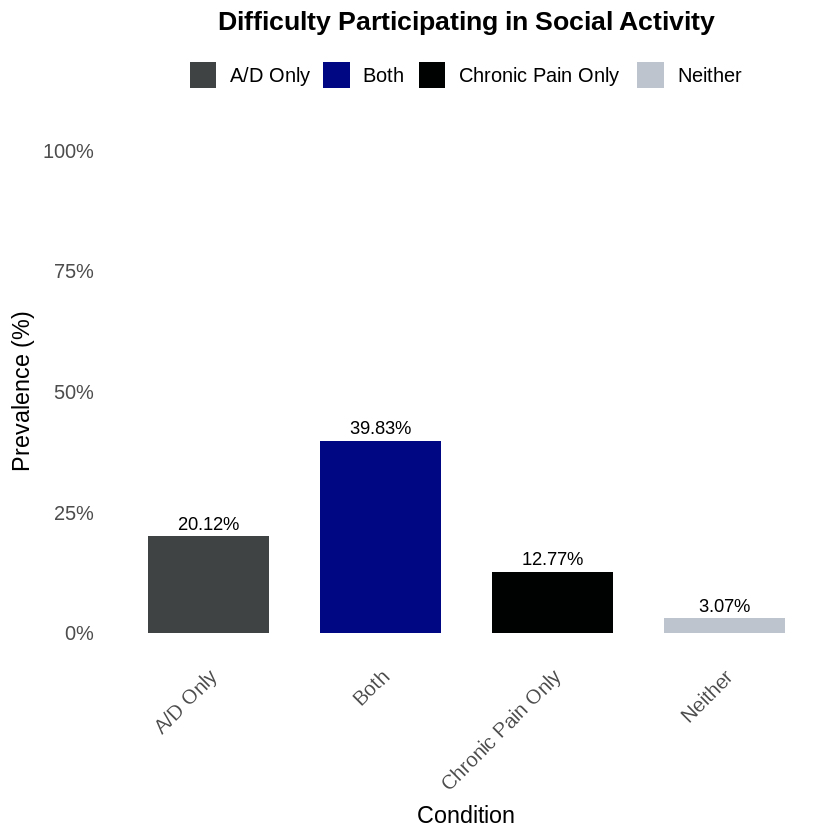

In [66]:
plot_SL <- ggplot(SL, aes(x = Condition, y = mean, fill = Condition)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  geom_text(aes(label = sprintf("%.2f%%", mean)), vjust = -0.5) +
  scale_fill_manual(values = c("#404343", "#000782", "#000101", "#BDC4CE")) +
  scale_y_continuous(labels = scales::percent_format(scale = 1), limits = c(0, 100)) +
  labs(title = "Difficulty Participating in Social Activity", x = "Condition", y = "Prevalence (%)") +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 12),
    legend.title = element_blank(),
    legend.text = element_text(size = 12),
    legend.position = "top",
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )
  plot_SL

###Visualizing eraned Limitations Across Health Conditions

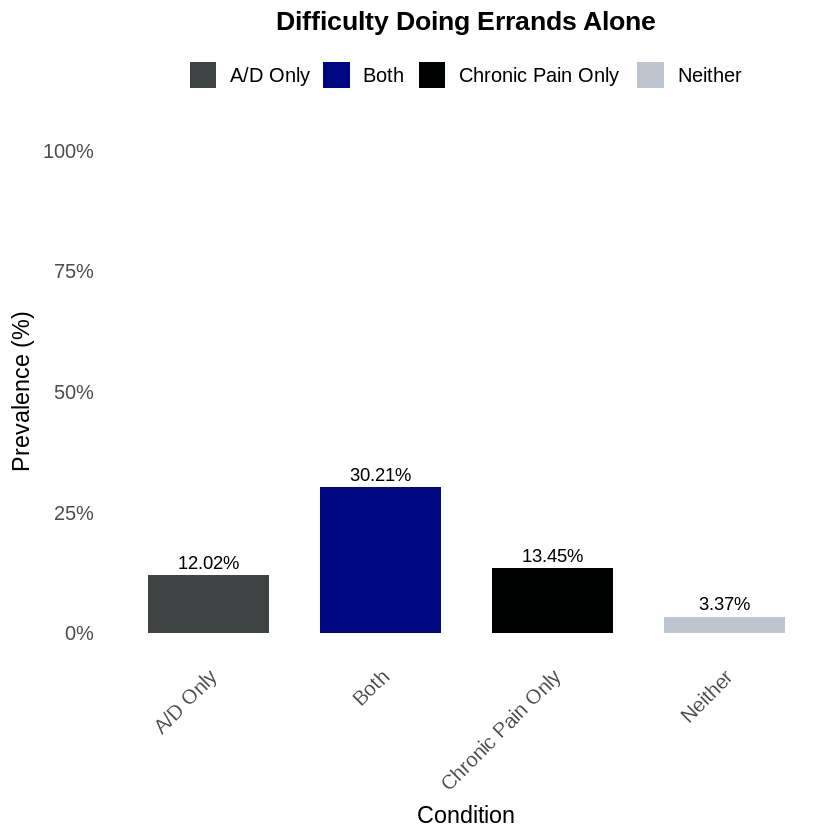

In [67]:
plot_EL <- ggplot(EL, aes(x = Condition, y = mean, fill = Condition)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  geom_text(aes(label = sprintf("%.2f%%", mean)), vjust = -0.5) +
  scale_fill_manual(values = c("#404343", "#000782", "#000101", "#BDC4CE")) +
  scale_y_continuous(labels = scales::percent_format(scale = 1), limits = c(0, 100)) +
  labs(title = "Difficulty Doing Errands Alone", x = "Condition", y = "Prevalence (%)") +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 12),
    legend.title = element_blank(),
    legend.text = element_text(size = 12),
    legend.position = "top",
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )
plot_EL

###Visualizing work Limitations Across Health Conditions

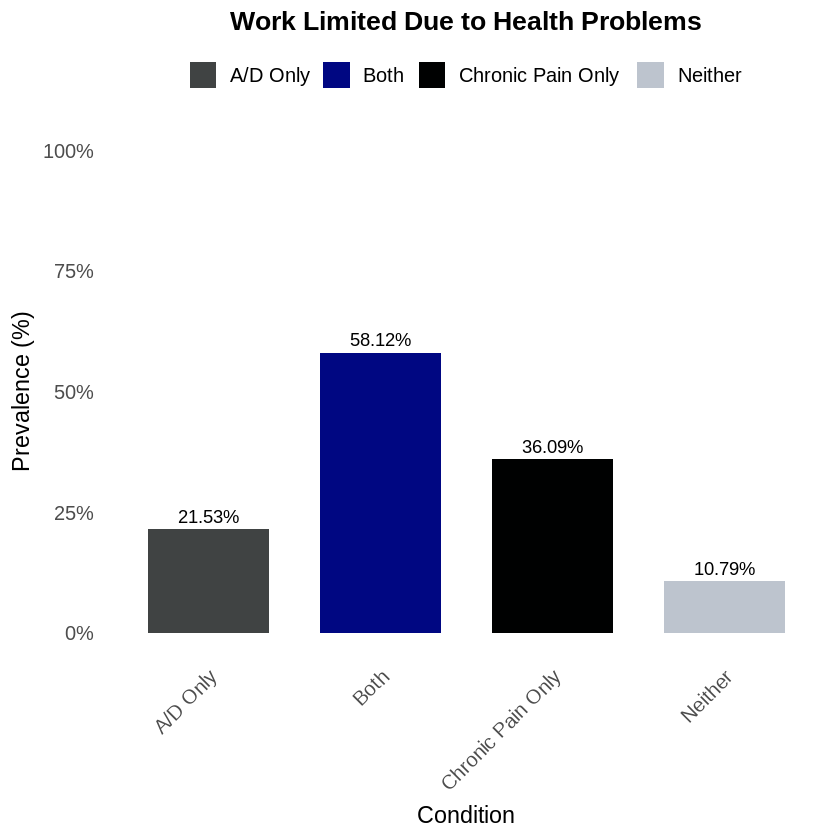

In [68]:
plot_WL <- ggplot(WL, aes(x = Condition, y = mean, fill = Condition)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  geom_text(aes(label = sprintf("%.2f%%", mean)), vjust = -0.5) +
  scale_fill_manual(values = c("#404343", "#000782", "#000101", "#BDC4CE")) +
  scale_y_continuous(labels = scales::percent_format(scale = 1), limits = c(0, 100)) +
  labs(title = "Work Limited Due to Health Problems", x = "Condition", y = "Prevalence (%)") +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 12),
    legend.title = element_blank(),
    legend.text = element_text(size = 12),
    legend.position = "top",
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )
  plot_WL

###Visualizing the general poor health Across Health Conditions

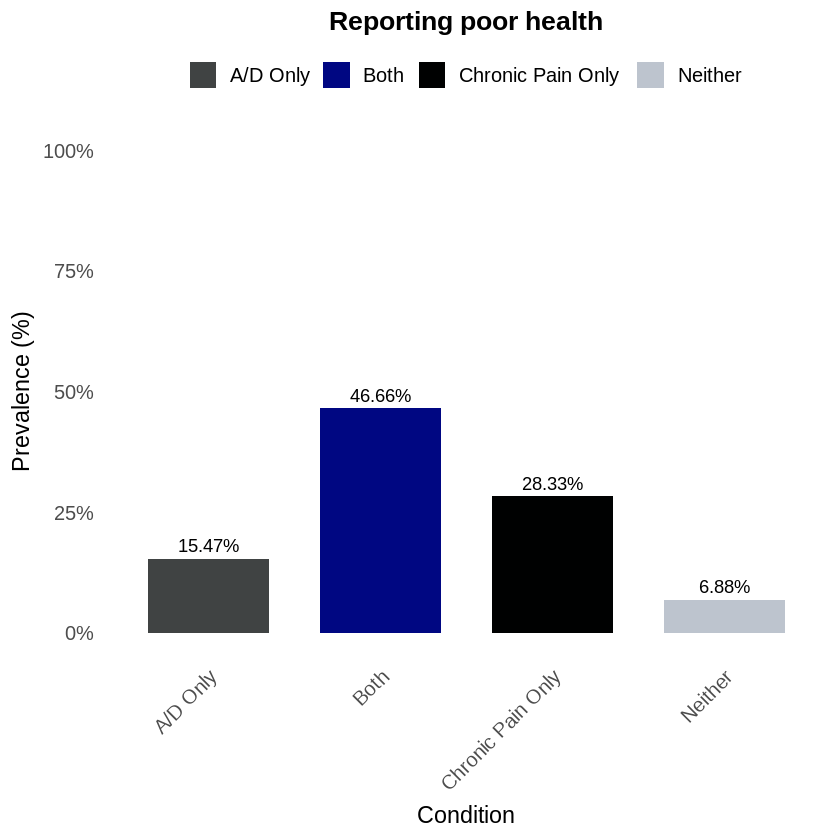

In [69]:
Helth.plt <- ggplot(Helth.ds, aes(x = Condition, y = mean, fill = Condition)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  geom_text(aes(label = sprintf("%.2f%%", mean)), vjust = -0.5) +
  scale_fill_manual(values = c("#404343", "#000782", "#000101", "#BDC4CE")) +
  scale_y_continuous(labels = scales::percent_format(scale = 1), limits = c(0, 100)) +
  labs(title = "Reporting poor health", x = "Condition", y = "Prevalence (%)") +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 12),
    legend.title = element_blank(),
    legend.text = element_text(size = 12),
    legend.position = "top",
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )
Helth.plt

###Visualizing overngits hospital visit Across Health Conditions

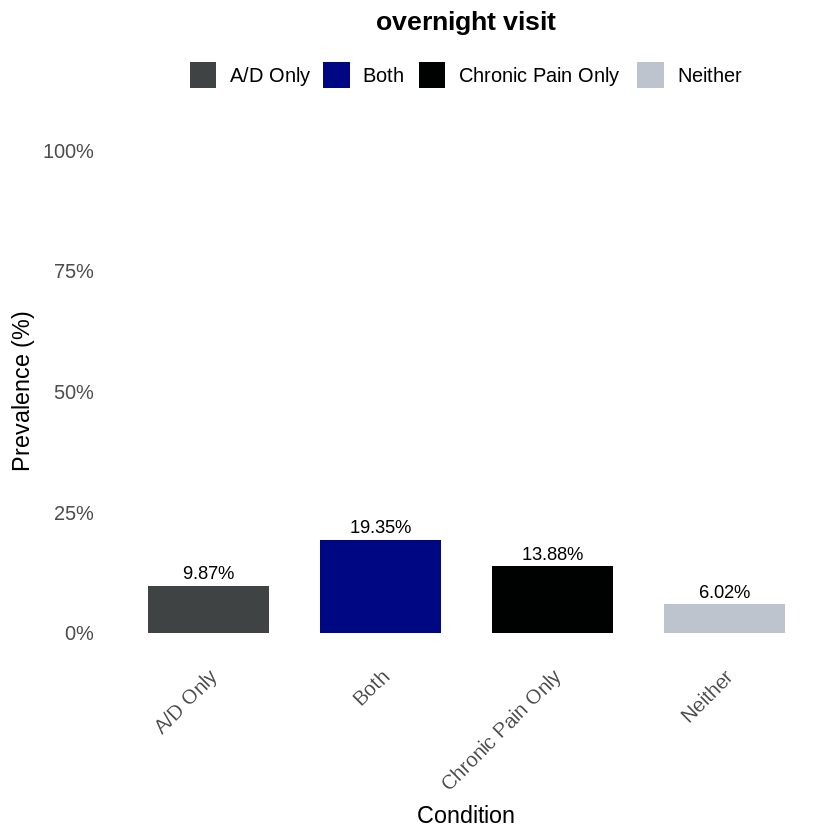

In [70]:
Overnight.plt <- ggplot(Overnight.ds, aes(x = Condition, y = mean, fill = Condition)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  geom_text(aes(label = sprintf("%.2f%%", mean)), vjust = -0.5) +
  scale_fill_manual(values = c("#404343", "#000782", "#000101", "#BDC4CE")) +
  scale_y_continuous(labels = scales::percent_format(scale = 1), limits = c(0, 100)) +
  labs(title = "overnight visit", x = "Condition", y = "Prevalence (%)") +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 12),
    legend.title = element_blank(),
    legend.text = element_text(size = 12),
    legend.position = "top",
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )
Overnight.plt

##Visualization of Functional Limitations by Health Condition


In [73]:
# Load necessary libraries
library(ggplot2)
library(dplyr)  # Assuming dplyr is needed for data manipulation
library(stringr)

# # Combine data into a single data frame
combined_data <- bind_rows(
  SL %>% mutate(Type = "Difficulty participating in social activity"),
  EL %>% mutate(Type = "Difficulty doing errands alone"),
  WL %>% mutate(Type = "Work limited due to health problems"),
  Helth.ds %>% mutate(Type = "Reporting poor general health"),
  Overnight.ds %>% mutate(Type = "Reporting overnight visit"),
)
# Function to wrap text
wrap_text <- function(text, width = 20) {
  str_wrap(text, width = width)
}
# Create the bar plot
plot <- ggplot(combined_data, aes(x = Type, y = mean, fill = Condition)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.8), width = 0.6) +
  geom_text(aes(label = paste0(mean, "%")),
            position = position_dodge(width = 0.8),
            vjust = -0.8,
            size = 4) +
  labs(
   x = NULL,  # Remove x-axis label
    y = "Prevalence (%)"
  ) +
  scale_fill_manual(values = c("#404343", "#000782", "#000101", "#BDC4CE"),  labels = c(
      "A/D Only" = "A/D only",
      "Chronic Pain Only" = "pain only",
      "Both" = "co-occurring",
      "Neither" = "Neither"
    )) +
  scale_y_continuous(labels = scales::percent_format(scale = 1), limits = c(0, 60)) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x = element_text(size = 14, color = "black"),  # Set color to black
    axis.text.y = element_text(size = 14, color = "black"),  # Set y-axis labels color to black
    legend.title = element_blank(),  # Remove the legend title
    legend.text = element_text(size = 18),
    legend.key.size = unit(1.5, "lines"),  # Increase the size of the legend keys
    strip.text = element_text(size = 14, color = "black"),  # Change facet labels color to black
    legend.position = "top",
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )+
  scale_x_discrete(labels = wrap_text)  # Wrap x-axis labels

# Save the plot with a 16:9 aspect ratio
ggsave("combined_conditions_plot.png", plot, width = 24, height = 9, units = "in", dpi = 300)
